In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [2]:
# Load Data
data_root = r''
expanded_data_df = pd.read_csv(os.path.join(data_root, "expanded_data.csv"))

In [3]:
# create seasonal team rankings
ranking_features = [
    'passing_yards',
    'passing_tds',
    'interceptions',
    'sacks',
    'sack_yards',
    'sack_fumbles',
    'sack_fumbles_lost',
    'passing_air_yards',
    'passing_yards_after_catch',
    'passing_first_downs',
    'passing_epa',
    'passing_two_point_conversions',
    'carries',
    'rushing_yards',
    'rushing_tds',
    'rushing_fumbles',
    'rushing_fumbles_lost',
    'rushing_first_downs',
    'rushing_epa',
    'rushing_two_point_conversions',
    'receiving_fumbles',
    'receiving_fumbles_lost',
    'special_teams_tds'
]

home_columns_to_rank = {'home_team_'+ f: f for f in ranking_features}
home_columns_to_rank.update({'home_score': 'score'})
home_extra_required_cols = ['year', 'week', 'home_team_name']

away_columns_to_rank = {'away_team_'+ f: f for f in ranking_features}
away_columns_to_rank.update({'away_score': 'score'})
away_extra_required_cols = ['year', 'week', 'away_team_name']


# practice on last season. on full set, group by year
home_test_df = expanded_data_df[
    (expanded_data_df.week.astype(str) != '1')
    ].loc[
        :, home_extra_required_cols + [*home_columns_to_rank.keys()]
    ].reset_index().rename(columns=home_columns_to_rank).rename(
        columns={'home_team_name': 'team_name', 'index': 'original_index'}
    )
home_test_df.insert(2, 'is_home', 1)

away_test_df = expanded_data_df[
    (expanded_data_df.week.astype(str) != '1')
    ].loc[
        :, away_extra_required_cols + [*away_columns_to_rank.keys()]
    ].reset_index().rename(columns=away_columns_to_rank).rename(
        columns={'away_team_name': 'team_name', 'index': 'original_index'}
    )

away_test_df.insert(2, 'is_home', 0)

test_df = pd.concat([home_test_df, away_test_df])
test_df['week'] = pd.to_numeric(test_df.week, 'coerce')
test_df = test_df.dropna().sort_values(['year', 'week']).reset_index(drop=True)

for feature in ranking_features:
    test_df['ranked_' + feature] = test_df.groupby(['year', 'week'])[feature].rank('dense')


In [4]:
feature_columns = [
    'ranked_' + feature for feature in ranking_features
] #+ [
    # 'home_team_fantasy_points',
# ]
feature_df = test_df.loc[:, feature_columns]
score_df = test_df.loc[:, 'score']

In [ ]:
# away_df = test_df[test_df.is_home == 0]
# home_df = test_df[test_df.is_home == 1]
# combined_df = pd.merge(away_df, home_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_df, score_df, test_size=0.20, random_state=42)

In [ ]:
# ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features',
# 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf',
# 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs',
# 'oob_score', 'random_state', 'verbose', 'warm_start']

rf_param_grid = {
    'bootstrap': [True],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": [1.0, "sqrt", "log2"],
    "max_depth": [1, 3, 5, 10, 20, 30, 40, 50],
}

rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf, param_grid=rf_param_grid, n_jobs=-2)
rf_grid_search.fit(X_train, y_train)

In [ ]:
rf_grid_search.best_estimator_
# RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=400)

In [ ]:
y_test_predict = rf_grid_search.predict(X_test)
# precision = precision_score(y_test, y_test_predict)
# accuracy = accuracy_score(y_test, y_test_predict)
# print('Accuracy:', accuracy), 'Precision:', precision)
r2 = r2_score(y_test, y_test_predict)
print('r2 score:', r2)
import matplotlib.pyplot as plt

x = range(len(y_test_predict))
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(x, y_test_predict, label='test_predict')
ax.scatter(x, y_test, label='test_actual')
fig.legend()
plt.show()

In [ ]:
# Preprocess Data
# scale numerical data. Imputation can probably be removed.
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# handle categorical columns with one-hot-encoding. Imputation can probably be removed.
categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_constant",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_preprocessor,
            [],  # TODO: add list of categorical columns
        ),
        ("numerical", numeric_preprocessor, []),  # TODO: add list of numerical columns
    ]
)

In [ ]:
# Create Logistic Regression Pipeline
lr_pipe = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", LogisticRegression()),
    ]
)

# Create Random Forest Regression Pipeline
rf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor())]
)

rf_param_grid = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_features": ["auto", "sqrt", "log2"],
    "classifier__max_depth": [1, 3, 5, 10, 20, 30, 40, 50],
}

rf_grid_search = GridSearchCV(rf_pipe, param_grid=rf_param_grid, n_jobs=1)
lr_grid_search = GridSearchCV(lr_pipe, n_jobs=1)

In [6]:
from pycaret.regression import RegressionExperiment

In [13]:
data = test_df.loc[:, feature_columns+['score']]

In [22]:
s = RegressionExperiment()
s.setup(data.loc[:, ['ranked_passing_tds', 'ranked_rushing_tds','ranked_passing_yards', 'ranked_rushing_yards', 'score']], target='score', session_id = 321)


,Description,Value
0,Session id,321
1,Target,score
2,Target type,Regression
3,Original data shape,"(10144, 5)"
4,Transformed data shape,"(10144, 5)"
5,Transformed train set shape,"(7100, 5)"
6,Transformed test set shape,"(3044, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [23]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,8.1190,103.0401,10.1485,0.0285,0.6207,0.5798,0.2880
lr,Linear Regression,8.1201,103.0741,10.1502,0.0282,0.6206,0.5795,0.0140
lasso,Lasso Regression,8.1212,103.0808,10.1505,0.0282,0.6208,0.5802,0.0110
ridge,Ridge Regression,8.1201,103.0741,10.1502,0.0282,0.6206,0.5795,0.3010
lar,Least Angle Regression,8.1201,103.0741,10.1502,0.0282,0.6206,0.5795,0.0080
llar,Lasso Least Angle Regression,8.1212,103.0808,10.1505,0.0282,0.6208,0.5802,0.0070
br,Bayesian Ridge,8.1204,103.0695,10.1500,0.0282,0.6206,0.5796,0.0070
huber,Huber Regressor,8.1184,103.1679,10.1547,0.0274,0.6178,0.5715,0.0080
gbr,Gradient Boosting Regressor,8.1412,103.4355,10.1676,0.0249,0.6200,0.5786,0.0350
ada,AdaBoost Regressor,8.1772,103.6686,10.1797,0.0224,0.6287,0.6025,0.0130


In [24]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

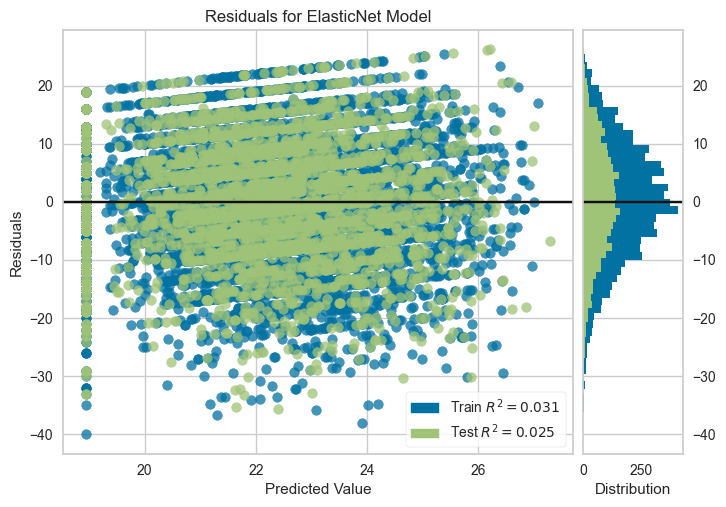

In [25]:
s.plot_model(best, plot = 'residuals')

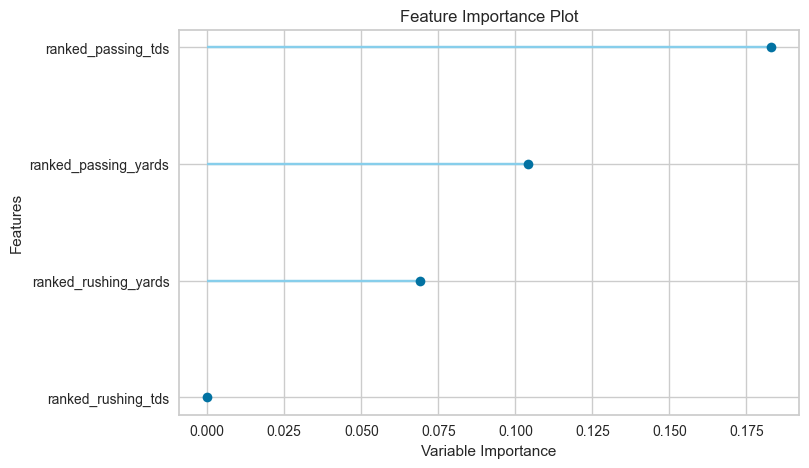

In [26]:
s.plot_model(best, plot = 'feature')